# 4. Anàlisi del dataset "Heart Attack Analysis & Dataset" 
En aquest notebook analitzarem les dades del joc de dades un cop aquestes han estat netejades,
és a dir, partim del fitxer data_heart_clean.csv.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.stats import shapiro, bartlett, ttest_ind, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# load the cleaned dataset
data_heart = pd.read_csv('input/heart_clean.csv')

# make column names list for each type of variable
numerical_variable_names = ['age', 'trtbps', 'chol', 'thalachh', 'log_oldpeak']
categorical_variable_names = [v for v in data_heart.columns if v not in numerical_variable_names]

## 4.1 Selecció dels grups de dades que es volen analitzar/comparar.

La primera part de l'anàlisi del joc de dades serà seleccionar quines variables volem utilitzar per estudiar quins paràmetres són indicadors d'una major probabilitat d'atac de cor. Per tal de fer aquesta selecció, primer analitzarem visualment com es distribueixen les variables explicatives depenent de si el pacient presenta major o menor probabilitat d'atac de cor. Aquesta probabilitat és la que bé proporcionada per variable "output", la qual és la variable a predir.

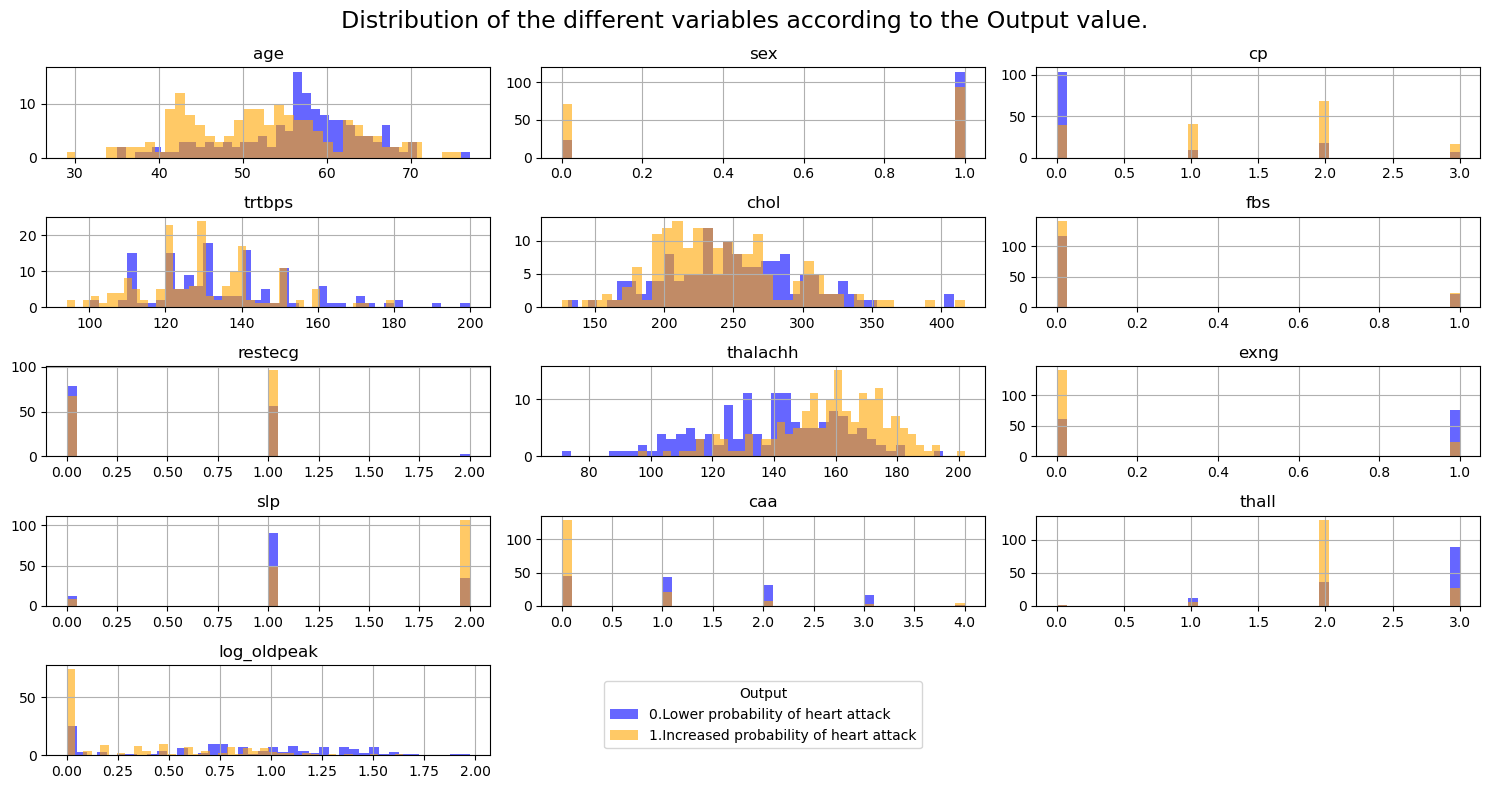

In [2]:
def plot_conditional_histograms(alpha=0.6):
    fig, axes = plt.subplots(5, 3, figsize=(15, 8))
    descriptive = [v for v in data_heart.columns if v != 'output']
    legend_ax = fig.add_subplot(111, frame_on=False)
    
    for i, v in enumerate(descriptive):
        ax = axes[i//3, i%3]
        data_heart.loc[data_heart['output']==0, v].hist(bins=40, ax=ax, alpha=alpha, color='blue', label="0.Lower probability of heart attack")
        data_heart.loc[data_heart['output']==1, v].hist(bins=40, ax=ax, alpha=alpha, color='orange', label="1.Increased probability of heart attack")
        ax.set_title(v)
    
    axes[4, 1].axis('off')
    axes[4, 2].axis('off')
    
    legend_ax.axis('off')
    legend_ax.legend(*ax.get_legend_handles_labels(), loc='lower center', title='Output')
    fig.add_subplot(legend_ax)
    
    fig.suptitle('Distribution of the different variables according to the Output value.', fontsize=17)
    fig.tight_layout()
    plt.show()

plot_conditional_histograms()

De primeres, podem afirmar que tots els histogrames obtinguts són prometedors, ja que les distribucions de les variables explicatives varien considerablement segons la categoria de la variable **Output**. A més, podem veure que algunes variables tenen una distribució més diferenciada que d'altres, fet que ens permetrà fer una idea inicial de quines variables explicatives seran les més rellevants per predir la variable **Output**.


A escala visual podem observar com les variables categòriques **thall**,**caa**,**slp**,**exng** i **cp** mostren una distinció més clara entre les dues categories de la variable **Output**. Això suggereix que aquestes variables explicatives seràn les que descriuran millor la variable a predir. Tot i així, en apartats posteriors realitzarem un estudi amb més profunditat per confirmar aquesta hipòtesi inicial.
Pel que fa a les variables numèriques, podem veure que en totes elles hi ha una superposició els dos tipus d'histogrames corresponent a cada categoria de la variable **Output** . Per tant, en aquest cas no és possible portar a cap una hipòtesi inicial respecte a quines variables seran les més rellevants i, per tant, serà necessari fer un estudi en més profunditat per identificar-les.


El estudi que durem a terme per establir quines variables explicaràn millor la variable **Output** serà el següent:

- Aplicar test d'hipòtesis per a cadascuna les variables numèriques per tal de determinar si existeixen diferències significatives entre els valors d'aquestes variables segons a quina categoria de la variable **Output** pertanyen. Si hi ha diferències significatives, significa que són variables rellevant per la predicció de **Output**.

- Elaborarem una anàlisi de correlacions entre les diferents variables numèriques i la variable **Output** per determinar com es relacionen entre si, si existeix col·linealitat entre variables numèriques i el grau de correlació que tenen amb la variable **Output**.

- Farem una anàlisi de les variables categòriques conjuntament amb la variable de sortida, calculant els seus corresponents coeficients de V-Cramer, per tal de determinar com es relacionen entre si i quines variables són més rellevants per la predicció de la variable **Output**.

- Finalment, generarem un model de regresió logística utilitzant les variables numèriques i categòriques seleccionades anteriorment com a rellevants per a predir la variable **Output**. Gràcies a la generació d'aquest model, podrem determinar si les variables seleccionades expliquen de forma òptima la variable **Output** mitjançant el càlcul de la precisió del model generat. 

## 4.2.a Anàlisi de la normalitat del joc de dades.

Procedim a elaborar una anàlisi de la normalitat de les variables numèriques que formen el joc de dades. Per fer aquesta anàlisi utilitzarem el test de Shapiro i Wilk.

El test de Shapiro i Wilk és un test d'hipòtesis que establirà com hipòtesi nul·la que la distribució de les observacions de la variable analitzada segueix una distribució normal. Per tant, mentre el p-value associat a la variable sigui superior al nivell de significança (en aquest cas establirem d'un 0,01), es podrà establir que hi ha evidència suficient per rebutjar la hipòtesis nul·la i afirmar que les dades segueixen una distribució no normal.

In [3]:
normality_results = {var: list(shapiro(data_heart[var])) for var in numerical_variable_names}

pd.DataFrame(normality_results, index=['statistic', 'p-value'])

,age,trtbps,chol,thalachh,log_oldpeak
statistic,0.986622,0.966081,0.982803,0.976608,8.896660e-01
p-value,0.006696,0.000002,0.001096,0.000077,5.537369e-14


En aquest cas, es pot afirmar amb una confiança superior al 99% que cap de les variables numèriques es distribueix normalment.

Així i tot, cal tenir en compte que depenent del nombre de mostres que tinguem per les dues categories possibles de la variable **Output**, pot ser possible aplicar el teorema del límit central (TLC), el qual estableix que el contrast d'hipòtesis sobre la mitjana d'una mostra s'aproxima a una distribució normal encara que la població original no segueixi aquesta distribució si la mostra té un nombre d'observacions elevat (aprox. major a 30).

In [4]:
# Check that there are more than 30 values for each value.
data_heart['output'].value_counts()

1    164
0    138
Name: output, dtype: int64

Si mirem la taula anterior, veiem que el nombre d'observacions per cadascuna de les categories de la variable **Outpot** és superior a 30, per tant, d'acord amb el TLC podem assumir que la mitjana mostral de les variables numèriques es distribueix normalment.

## 4.2.b Anàlisi de la homoscedasticitat del joc de dades.

Procedim a elaborar una anàlisi de la igualtat de variància entre les observacions de les variables numèriques segons el tipus de categoria de la variable **Output**. Per fer aquesta anàlisi utilitzarem el test de Bartlett. 

El test de Bartlett és un test d'hipòtesis que s'aplica en variable distribuïda normalment, que establirà com hipòtesi nul·la que la variància de les observacions de la variable per cada categoria serà igual. Per tant, mentre el p-value associat a la variable sigui major al nivell de significança (en aquest cas establirem d'un 0,05), es podrà establir que les dades de la variable segons el tipus de **Output** compleixen el criteri d'homoscedasticitat.

In [5]:
homoscedasticity_results = {
    var: list(bartlett(
        data_heart[data_heart['output'] == 0][var],
        data_heart[data_heart['output'] == 1][var]
    )) for var in numerical_variable_names
}


homoscedasticty_results_df = pd.DataFrame(homoscedasticity_results, index=['statistic', 'p-value'])
homoscedasticty_results_df

,age,trtbps,chol,thalachh,log_oldpeak
statistic,4.621701,3.192989,0.268626,3.87912,8.720618
p-value,0.031570,0.073955,0.604255,0.04889,0.003146


En aquest cas, podem confirmar amb un 95% de confiança que les variables numèriques **trtbps** i **chol** segons la categoria de la variable **Output** compleixen amb el criteri d'homoscedasticitat. Mentre que les variables **age**, **thalachh** i **log_oldpeak** compliran amb el criteri d'heteroscedasticitat.

## 4.3 Estudi estadístic de les variables seleccionades respecte la variable Output.

### Test d'hipotesis 

A continuació es portarà a terme un conjunt de test d'hipòtesis per determinar si existeixen diferències significatives entre els grups corresponents a cada categoria de la variable **Output** per les diferents variables numèriques del joc de dades. Aquelles variables que no presentin diferències significatives amb un 95% de confiança seran descartades del model de regressió logístic final.

Cal tenir en compte que en aquest cas les variables a analitzar poden presentar criteri d'homoscedasticitat o no, per tant, com a test d'hipòtesis aplicarem el t-test de Welch el qual és apte pels dos casos.

In [6]:
def check_equality_in_mean():
    n_num_vars = len(numerical_variable_names)
    results_table = pd.DataFrame(0, columns=numerical_variable_names, index=['statistic', 'p-value'])
    for var in numerical_variable_names:
        data_0 = data_heart.loc[data_heart['output']==0, var]
        data_1 = data_heart.loc[data_heart['output']==1, var]
        _, p_mean = ttest_ind(data_0, data_1, equal_var=False)
        results_table.loc['statistic', var] = _
        results_table.loc['p-value', var] = p_mean
    return results_table

print("Results from the hipotesis test of means by restricting to each class:")
equality_in_mean_results = check_equality_in_mean()  
equality_in_mean_results

Results from the hipotesis test of means by restricting to each class:


,age,trtbps,chol,thalachh,log_oldpeak
statistic,4.169903,2.461914,1.930037,-7.930994e+00,8.205121e+00
p-value,0.000040,0.014439,0.054589,5.763131e-14,1.105115e-14


En aquest cas, podem confirmar amb un 95% de confiança que totes les variables numèriques tenen diferències significatives respecte a la categoria de la variable **Output** amb l'excepció de la variable **chol**.

Amb els resultats obtinguts tant en el test d'hipòtesis com en l'anàlisi d'homoscedasticitat realitzats anteriorment, podem conclure que tant la variable numèrica **chol** com la variable numèrica **trtbps** aporten menys informació respecte a la variable **output** que la resta de variables numèriques. En conseqüència, no seran considerades com a rellevants per explicar la variable a predir.

Podem veure la representació gràfica dels p-values de cada variable en el següent gràfic (p -values majors (en ocre) o menors (en negre) al nivell de significança de 0,05).

Text(0.5, 1.0, 'P-values over the significance level')

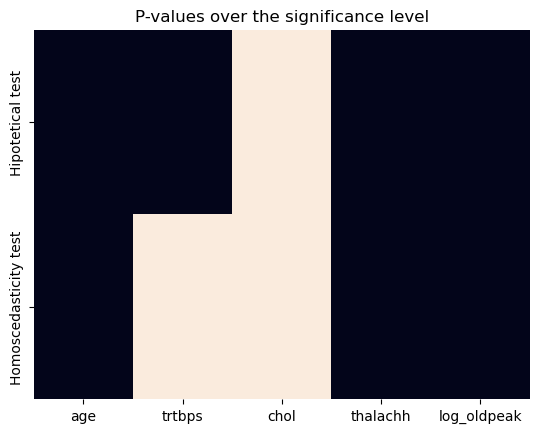

In [7]:
p_mean = pd.DataFrame(equality_in_mean_results.loc['p-value']).rename(columns={'p-value': 'Hipotetical test'}).transpose()
p_variance = pd.DataFrame(homoscedasticty_results_df.loc['p-value']).rename(columns={'p-value': 
                                                                                     'Homoscedasticity test'}).transpose()

p_values_df = pd.concat([p_mean, p_variance])

p_values_heatmap = sn.heatmap(p_values_df > 0.05, cbar=False)
p_values_heatmap.set_title("P-values over the significance level")


### Matriu de correlació de les variables numèriques.

A continuació realitzarem una matriu de correlacions que ens permetrà determinar com es relacionen les diferents variables numèriques entre si i amb la variable **Output**.

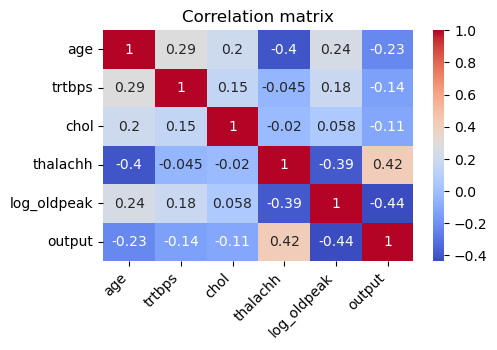

In [8]:
numerical_variable_names_with_output = ['age', 'trtbps', 'chol', 'thalachh', 'log_oldpeak', 'output']
numerical_data_heart = data_heart[numerical_variable_names_with_output]
correlation_matrix = numerical_data_heart.corr()

fig, ax = plt.subplots(figsize=(5, 3))
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_xticklabels(correlation_matrix.columns, rotation=45, horizontalalignment='right')
ax.set_yticklabels(correlation_matrix.columns, rotation=0)

ax.set_title('Correlation matrix')
plt.show()

Sabem que una elevada correlació entre variables numèriques independentment del signe és indicativa d'una possible col·linealitat, fet que cal tenir en compte en realitzar el model de regressió logística final. Veiem que hi ha una possible col·linealitat entre les variables **age**-**thalachh** i les variables **thalachh**-**log_oldpeak**.

Així i tot, si observem la correlació obtinguda entre les variables numèriques i la variable de sortida veiem que **log_oldpeak** i **thalachh** són les que estan més correlacionades. En conseqüència, a l'hora de generar el model de regressió logística sols seleccionarem aquestes dues variables numèriques, ja que són les úniques que es poden considerar com a rellevants per explicar la variable a predir. Veiem que s'elimina el possible problema de col·linealitat entre **age**-**thalachh** , però no entre **thalachh**-**log_oldpeak**. Serà necessari comprovar si el problema és tan greu com per haver d'eliminar una de les dues mitjançant el càlcul del [VIF](https://www.statology.org/how-to-calculate-vif-in-python/) .

In [9]:
# calculate VIF
collineallity_problem = data_heart[['thalachh', 'log_oldpeak']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(collineallity_problem.values, i) for i in range(collineallity_problem.shape[1])]
vif['variable'] = collineallity_problem.columns

print(vif)

        VIF     variable
0  1.894564     thalachh
1  1.894564  log_oldpeak


Com podem veure el VIF obtingut es troba dins del rang entre 1 i 5, per tant, es descarta que pugui haver-hi problemes de multicol·linealitat i seleccionem les dues variables numèriques.

### Matriu de coeficients V-Cramer de les variables categòriques.

A continuació realitzarem una matriu de coeficients V-Cramer que ens permetrà determinar com es relacionen les diferents variables categòriques entre si i amb la variable **Output**.

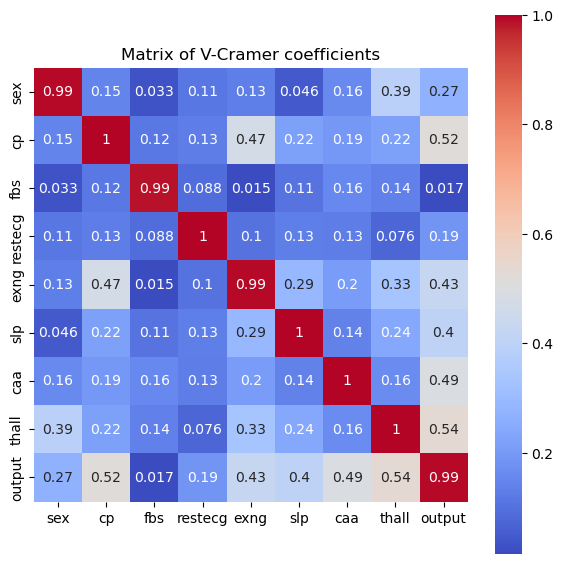

In [10]:
categorical_data_heart = data_heart[categorical_variable_names]
correlation_matrix = pd.DataFrame(index=categorical_variable_names, columns=categorical_variable_names)

for var1 in categorical_variable_names:
    for var2 in categorical_variable_names:
        
        contingency_table = pd.crosstab(data_heart[var1], data_heart[var2])
        
        chi2 = chi2_contingency(contingency_table)[0]
        total_values = contingency_table.sum().sum()
        minDim = min(contingency_table.shape)-1    
        vcramer = np.sqrt((chi2 / total_values)/minDim)
        
        correlation_matrix.loc[var1, var2] = vcramer
        
# Convert the correlation matrix values to float
correlation_matrix = correlation_matrix.astype(float)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(7, 7))
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Matrix of V-Cramer coefficients')
plt.show()

Podem observar que l'associació entre les diferents variables categòriques explicatives és majoritàriament dèbil, ja que els coeficients V-Cramers obtinguts es troben dins del rang de [0,0.3], encara que es pot apreciar una associació mitjana per les variables **exng**-**thall**, **cp**-**exng** i **sex**-**thall**. Aquesta associació mitjana de primeres no caldria tenir-la en compte en dur a terme el model de regressió, ja que no hauria de generar problemes de col·linealitat que afectessin la precisió del model. Així i tot, es comprovarà aquest fet generant dos models de regressió i comparant la precisió assolida.

Si ens fixem en els coeficients assolits per les diferents variables categòriques respecte a la variable **Output**, podem veure que només les variables **sex**, **fbs** i **restecg** presenten una associació dèbil. Per tant, aquestes variables seran descartades per a la creació del model de regressió logística.

En definitiva, les variables **cp**, **exng**, **slp**, **ca** i **thall**, ja que són les úniques que es poden considerar com a rellevants per explicar la variable a predir.

### Regresió logística.

A continuació durem a terme la generació d'un model que ens permetra predir el output de futurs pacients. Gracies a aquest model es podrà determinar com de bones son les variables seleccionades per predir la variable de sortida i com es relacionen amb aquesta. 

In [11]:
X = data_heart[['cp','exng', 'slp', 'caa', 'thall','thalachh', 'log_oldpeak']]
y = data_heart[['output']]
y = y.values.ravel()
X = pd.get_dummies(X, drop_first=True)  

# generate train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)


# initialize regresion model
logistic_model = LogisticRegression(max_iter = 1000)

logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

# evaluate the accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Percentage of accuracy from the logistic regresion model: {:.2f} %.  \n".format(accuracy*100))

# Obtain the coeficients 
coefficients = logistic_model.coef_

coeff_df = pd.DataFrame(coefficients, columns=X.columns)
print("Coefficient of each variable in the regresion logístic model: \n\n {}".format(coeff_df))

Percentage of accuracy from the logistic regresion model: 85.71 %.  

Coefficient of each variable in the regresion logístic model: 

          cp      exng       slp       caa     thall  thalachh  log_oldpeak
0  0.735234 -0.920938  0.214352 -0.586752 -1.050391   0.01778    -1.029652


Podem observar que el model de regressió logística generat per predir la variable **Output** segons totes les variables seleccionades com a rellevants en les anàlisis anteriors presenta una elevada precisió (85.71%). Per tant, es pot determinar que les variables explicatives seleccionades generen un model valid pera predir el tipus de probabilitat que té el pacient de patir un atac cardíac.

A continuació, com hem dit en la matriu de V-Cramer, comprovarem si en eliminar la variable **exng** i **thall**, millora o no la precisió del model generat.

In [12]:
X_2 = data_heart[['cp', 'slp', 'caa','thalachh', 'log_oldpeak']]
y_2 = data_heart[['output']]
y_2 = y_2.values.ravel()
X_2 = pd.get_dummies(X_2, drop_first=True)  

# generate train and test set
X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=48)

# initialize regresion model 2
logistic_model_2 = LogisticRegression(max_iter = 1000)

logistic_model_2.fit(X_train, y_train)
y_pred_2 = logistic_model_2.predict(X_test)

# evaluate the accuracy
accuracy = metrics.accuracy_score(y_test, y_pred_2)
print("Percentage of accuracy from the logistic regresion model: {:.2f} %.  \n".format(accuracy*100))

# Obtain the coeficients 
coefficients = logistic_model_2.coef_
coeff_df = pd.DataFrame(coefficients, columns=X_2.columns)
print("Coefficient of each variable in the regresion logístic model: \n\n {}".format(coeff_df))

Percentage of accuracy from the logistic regresion model: 82.42 %.  

Coefficient of each variable in the regresion logístic model: 

          cp       slp       caa  thalachh  log_oldpeak
0  0.871597  0.261667 -0.618158  0.020345    -1.098831


Podem observar que el nou model de regressió logística generat per predir la variable **Output** presenta una menor precisió respecte al model de regressió logñistica generat anteriorment. En conseqüencia, ens quedarem amb el model de regressió logística anterior.




## 6. Resolució del problema. 

Després d'haver realitzat l'estudi sobre el joc de dades, podem afirmar que les variables explicatives **cp**, **exng**, **slp**, **caa**, **thall**, **thalachh** i **log_oldpeak** són els paràmetres clau per determinar si un pacient té menor o major probabilitat de patir un atac de cor.

Podem observar que a mesura que els valors de les variables **cp**, **slp** i **thalachh** augmentin, la probabilitat d'obtenir la categoria "1.Increased probability of heart attack" en comparació a la categoria "0.Lower probability of heart attack" en la variable **Output** augmentarà.

D'altra banda, a mesura que els valors de les variables **caa** i **log_oldpeak** augmentin, la probabilitat d'aconseguir la categoria "1.Increased probability of heart attack" en comparació a la categoria "0.Lower probability of heart attack" en la variable **Output** disminuirà.

En conclusió, gràcies a les relacions establertes entre les variables explicatives seleccionades i la variable a predir **Output**, ara tenim un model que ens permet detectar amb una precisió del 85,71% quins pacients tenen una major probabilitat d'atac de cor. Aquest model permetrà als metges centrar els recursos específics en aquests casos, reduint despeses econòmiques i millorant l'atenció especialitzada al pacient.